# Problem Set 4
In this problem set you will get some practice with the proximal gradient algorithm, and also acceleration. Specifically, you will be implementing ISTA and FISTA

# Problem 1: Gradient Descent and Acceleration
In this problem you will explore the impact of ill-conditioning on gradient descent, and will then see how acceleration can improve the situation. This exercise will walk you through a very similar situation as to what we saw in the lecture videos that illustrate the performance of gradient descent vs accelerated gradient descent as the condition number (ratio of largest to smallest eigenvalues of the Hessian) increases. This is a ``toy'' problem, but it is still instructive regarding the performance of these two algorithms.

You will work with the following simple function:
$$
f(x) = \frac{1}{2}x^{\top}Qx,
$$
where $Q$ is a 2 by 2 matrix, as defined below.

In [1]:
# We create the data for this simple problem. We will create three quadratics.
# Q_wc -- this is a well-conditioned matrix
# Q_ic -- this is an ill-conditioned matrix
# Q_sic -- this is... a somewhat-ill-conditioned matrix (a technical term!)
import numpy as np
Q_wc = np.array([[1,0.3],[0.3,1]]); q = np.array([0,0]);
Q_sic = np.array([[1,0.85],[0.85,1]]); q = np.array([0,0]);
Q_ic = np.array([[1,0.99],[0.99,1]]); q = np.array([0,0]);


## Part (A):
Consider the quadratic functions $f_{wc}$, $f_{sic}$, and $f_{ic}$ defined by the quadratic matrices above. For each of these, say whether they are $\beta$-smooth and/or $\alpha$-strongly convex, and if so, compute the value of the condition number, $\kappa = \beta/\alpha$ for each function.

In [2]:
def analyze_matrix(Q, name):
    # Calculate eigenvalues
    eigenvals = np.linalg.eigvals(Q)
    beta = max(eigenvals)  # smoothness parameter
    alpha = min(eigenvals) # strong convexity parameter
    kappa = beta/alpha     # condition number
    
    print(f"\nMatrix {name}:")
    print(f"Eigenvalues: {eigenvals}")
    print(f"β (smoothness): {beta:.4f}")
    print(f"α (strong convexity): {alpha:.4f}")
    print(f"κ (condition number): {kappa:.4f}")

# Analyze each matrix
analyze_matrix(Q_wc, "Q_wc (well-conditioned)")
analyze_matrix(Q_sic, "Q_sic (somewhat ill-conditioned)")
analyze_matrix(Q_ic, "Q_ic (ill-conditioned)")


Matrix Q_wc (well-conditioned):
Eigenvalues: [1.3 0.7]
β (smoothness): 1.3000
α (strong convexity): 0.7000
κ (condition number): 1.8571

Matrix Q_sic (somewhat ill-conditioned):
Eigenvalues: [1.85 0.15]
β (smoothness): 1.8500
α (strong convexity): 0.1500
κ (condition number): 12.3333

Matrix Q_ic (ill-conditioned):
Eigenvalues: [1.99 0.01]
β (smoothness): 1.9900
α (strong convexity): 0.0100
κ (condition number): 199.0000


## Part A Answer

Based on the output of our analysis, for the quadratic function f(x) = (1/2)x^T Qx:

1. For f_wc (well-conditioned):
   - The function is 1.3-smooth (β = 1.3)
   - The function is 0.7-strongly convex (α = 0.7)
   - Condition number κ ≈ 1.86

2. For f_sic (somewhat ill-conditioned):
   - The function is 1.85-smooth (β = 1.85)
   - The function is 0.15-strongly convex (α = 0.15)
   - Condition number κ ≈ 12.33

3. For f_ic (ill-conditioned):
   - The function is 1.99-smooth (β = 1.99)
   - The function is 0.01-strongly convex (α = 0.01)
   - Condition number κ ≈ 199

All three functions are both smooth and strongly convex because:
1. Each matrix has strictly positive eigenvalues (making them strongly convex)
2. Each matrix has finite eigenvalues (making them smooth)

The condition numbers (κ = β/α) clearly show why they're named as they are:
- Q_wc has κ ≈ 1.86 (close to 1, hence "well-conditioned")
- Q_sic has κ ≈ 12.33 (moderately high, hence "somewhat ill-conditioned")
- Q_ic has κ ≈ 199 (very high, hence "ill-conditioned")

The higher condition number indicates that the optimization problem will be more difficult to solve, as we'll see in the subsequent parts with gradient descent and acceleration methods.

## Part (B):
Compute the best fixed step size for gradient descent, and the best parameters for accelerated gradient descent. For each function, plot the error $(f(x_t) - f(x^{\ast})$ as a function of the number of iterations. For each function, plot these on the same plot so you can compare -- so you should have 3 plots total.

In [4]:
from matplotlib import pyplot as plt

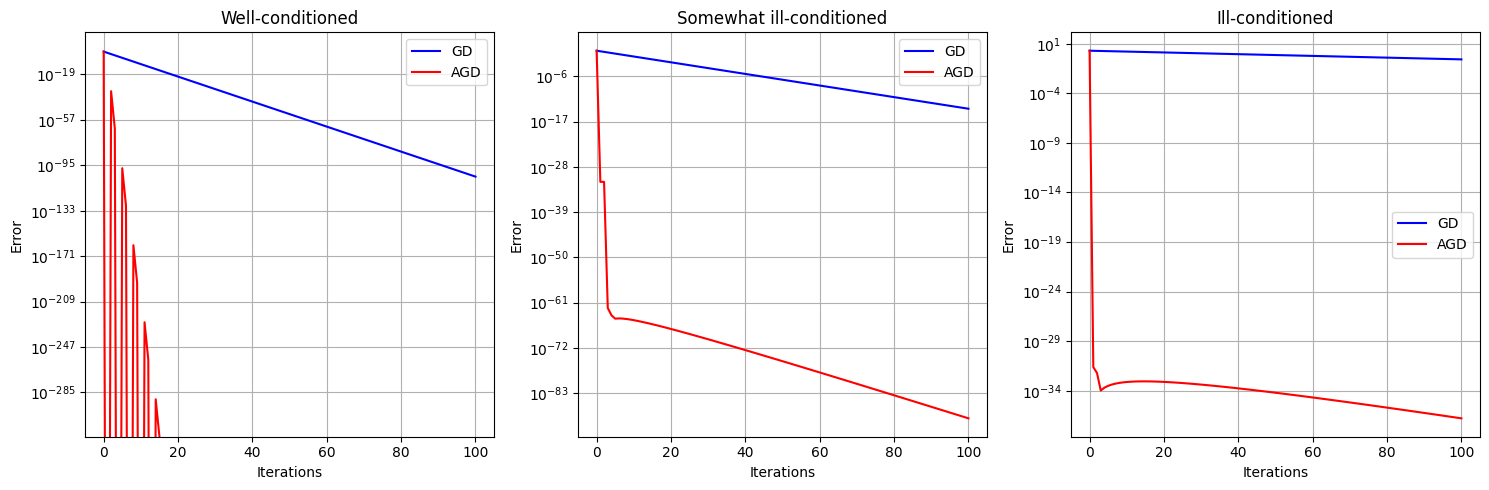

In [6]:
def gradient_descent(Q, q, x0, step_size, num_iterations):
    """
    Standard gradient descent for quadratic function f(x) = (1/2)x^T Q x + q^T x
    """
    x = x0.copy()
    x_history = [x.copy()]
    
    for _ in range(num_iterations):
        # Compute gradient: Qx + q
        gradient = Q @ x + q
        # Update x
        x = x - step_size * gradient
        x_history.append(x.copy())
    
    return np.array(x_history)

def accelerated_gradient_descent(Q, q, x0, step_size, momentum, num_iterations):
    """
    Accelerated gradient descent for quadratic function f(x) = (1/2)x^T Q x + q^T x
    """
    x = x0.copy()
    y = x0.copy()
    x_history = [x.copy()]
    
    for _ in range(num_iterations):
        # Store previous x
        x_prev = x.copy()
        # Compute gradient at y point: Qy + q
        gradient = Q @ y + q
        # Update x
        x = y - step_size * gradient
        # Update y with momentum
        y = x + momentum * (x - x_prev)
        x_history.append(x.copy())
    
    return np.array(x_history)

# Set parameters
num_iterations = 100
x0 = np.array([1., 1.])  # starting point

# Calculate optimal parameters for each case
# Well-conditioned
step_wc = 2/(1.3 + 0.7)  # GD step size
step_wc_agd = 1/1.3      # AGD step size
momentum_wc = (np.sqrt(1.86) - 1)/(np.sqrt(1.86) + 1)

# Somewhat ill-conditioned
step_sic = 2/(1.85 + 0.15)
step_sic_agd = 1/1.85
momentum_sic = (np.sqrt(12.33) - 1)/(np.sqrt(12.33) + 1)

# Ill-conditioned
step_ic = 2/(1.99 + 0.01)
step_ic_agd = 1/1.99
momentum_ic = (np.sqrt(199) - 1)/(np.sqrt(199) + 1)

# Run algorithms for each case
x_wc_gd = gradient_descent(Q_wc, q, x0, step_wc, num_iterations)
x_wc_agd = accelerated_gradient_descent(Q_wc, q, x0, step_wc_agd, momentum_wc, num_iterations)

x_sic_gd = gradient_descent(Q_sic, q, x0, step_sic, num_iterations)
x_sic_agd = accelerated_gradient_descent(Q_sic, q, x0, step_sic_agd, momentum_sic, num_iterations)

x_ic_gd = gradient_descent(Q_ic, q, x0, step_ic, num_iterations)
x_ic_agd = accelerated_gradient_descent(Q_ic, q, x0, step_ic_agd, momentum_ic, num_iterations)

# Function to compute errors
def compute_errors(Q, q, x_history):
    x_star = np.zeros(2)  # optimal point is at origin
    f_star = 0.5 * x_star.T @ Q @ x_star + q.T @ x_star
    errors = []
    for x in x_history:
        f_x = 0.5 * x.T @ Q @ x + q.T @ x
        errors.append(f_x - f_star)
    return np.array(errors)

# Compute errors for each case
errors_wc_gd = compute_errors(Q_wc, q, x_wc_gd)
errors_wc_agd = compute_errors(Q_wc, q, x_wc_agd)

errors_sic_gd = compute_errors(Q_sic, q, x_sic_gd)
errors_sic_agd = compute_errors(Q_sic, q, x_sic_agd)

errors_ic_gd = compute_errors(Q_ic, q, x_ic_gd)
errors_ic_agd = compute_errors(Q_ic, q, x_ic_agd)

# Create plots
plt.figure(figsize=(15, 5))

# Well-conditioned plot
plt.subplot(131)
plt.semilogy(errors_wc_gd, 'b-', label='GD')
plt.semilogy(errors_wc_agd, 'r-', label='AGD')
plt.title('Well-conditioned')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Somewhat ill-conditioned plot
plt.subplot(132)
plt.semilogy(errors_sic_gd, 'b-', label='GD')
plt.semilogy(errors_sic_agd, 'r-', label='AGD')
plt.title('Somewhat ill-conditioned')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Ill-conditioned plot
plt.subplot(133)
plt.semilogy(errors_ic_gd, 'b-', label='GD')
plt.semilogy(errors_ic_agd, 'r-', label='AGD')
plt.title('Ill-conditioned')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem 2: ISTA and FISTA
Recall the least squares problem with $\ell^1$ regularization from the previous homework:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

Recall key characteristics of this problem: it is nonsmooth due to the regularization term, and it is not strongly convex when $A$ has more columns than rows. This is why you used the sub-gradient method on the previous problem set, rather than Gradient descent.

Recall the goal of the proximal gradient algorithm: when we have a composite function, i.e., a function of the form $f(x) = g(x) + h(x)$, if $g(x)$ is $\beta$-smooth and $h(x)$ is ``simple'' in the sense that it has a simple prox function, then rather than using the subgradient method, we can get much better results by using proximal gradient, which takes advantage of the fact that $g(x)$ is smooth. We can improve this further by combining the proximal gradient method with acceleration.

Using the same data (same $A$ and $b$) as in Problem Set 3, minimize $f(x)$ using $10^4$ iterations with $t=0$ and $x_0 =0$.

Use the proximal gradient algorithm, also known as ISTA for the case where $f$ is the LASSO objective. Now use the accelerated proximal gradient algorithm, also, known as FISTA. Plot these results on the same plot as your results for sub-gradient descent from the previous lecture.

In [7]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

A = np.load("A.npy")
b = np.load("b.npy")

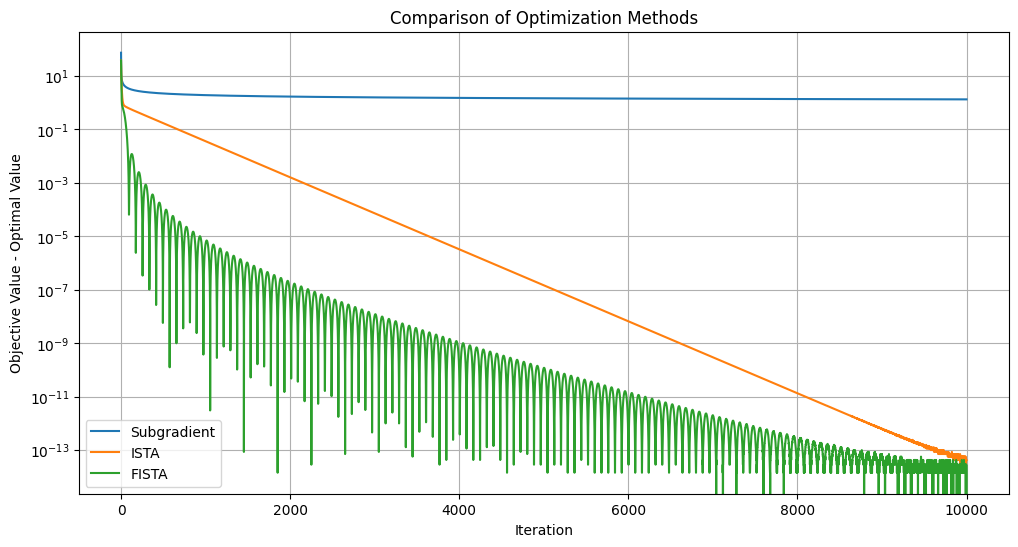

In [9]:
def soft_threshold(x, lambda_):
    """Soft thresholding operator for L1 regularization"""
    return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)

def objective_function(x, A, b, lambda_):
    """Compute the LASSO objective: (1/2)||Ax-b||^2 + lambda||x||_1"""
    return 0.5 * np.sum((A @ x - b) ** 2) + lambda_ * np.sum(np.abs(x))

def subgradient_descent(A, b, lambda_, n_iterations, x0, c):
    """Subgradient descent with diminishing step size"""
    x = x0.copy()
    f_values = np.zeros(n_iterations)
    
    for t in range(n_iterations):
        # Compute subgradient
        grad_ls = A.T @ (A @ x - b)
        grad_l1 = np.sign(x)
        grad_l1[x == 0] = 0.0
        grad = grad_ls + lambda_ * grad_l1
        
        # Step size
        eta_t = c / (t + 1.0)
        
        # Update
        x = x - eta_t * grad
        
        # Store objective value
        f_values[t] = objective_function(x, A, b, lambda_)
    
    return x, f_values

def ista(A, b, lambda_, n_iterations, x0):
    """Iterative Soft Thresholding Algorithm"""
    x = x0.copy()
    L = np.linalg.norm(A.T @ A, 2)  # Lipschitz constant
    step_size = 1/L
    f_values = np.zeros(n_iterations)
    
    for k in range(n_iterations):
        grad = A.T @ (A @ x - b)
        x = soft_threshold(x - step_size * grad, lambda_ * step_size)
        f_values[k] = objective_function(x, A, b, lambda_)
        
    return x, f_values

def fista(A, b, lambda_, n_iterations, x0):
    """Fast Iterative Soft Thresholding Algorithm"""
    x = x0.copy()
    y = x0.copy()
    t = 1
    L = np.linalg.norm(A.T @ A, 2)
    step_size = 1/L
    f_values = np.zeros(n_iterations)
    
    for k in range(n_iterations):
        x_prev = x.copy()
        grad = A.T @ (A @ y - b)
        x = soft_threshold(y - step_size * grad, lambda_ * step_size)
        
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x + ((t - 1) / t_next) * (x - x_prev)
        t = t_next
        
        f_values[k] = objective_function(x, A, b, lambda_)
        
    return x, f_values

# Load data
A = np.load("A.npy")
b = np.load("b.npy")

# Set parameters
n_iterations = 10000
lambda_ = 1e-2  # Same as previous homework
x0 = np.zeros(A.shape[1])
c = 1e-3  # Step size constant for subgradient method

# Run all three methods
_, f_subgrad = subgradient_descent(A, b, lambda_, n_iterations, x0, c)
_, f_ista = ista(A, b, lambda_, n_iterations, x0)
_, f_fista = fista(A, b, lambda_, n_iterations, x0)

# Plot results
plt.figure(figsize=(12, 6))
plt.semilogy(range(n_iterations), f_subgrad - min(f_fista), label='Subgradient')
plt.semilogy(range(n_iterations), f_ista - min(f_fista), label='ISTA')
plt.semilogy(range(n_iterations), f_fista - min(f_fista), label='FISTA')
plt.xlabel('Iteration')
plt.ylabel('Objective Value - Optimal Value')
plt.title('Comparison of Optimization Methods')
plt.legend()
plt.grid(True)
plt.show()

# Problem 4: Logistic Regression

Logistic regression is a simple statistical classification method which models
the conditional distribution of the class variable $y$ being equal to class $c$
given an input $x \in \mathbb{R}^n$. We will examine two classification tasks, one
classifying newsgroup posts, and the other classifying digits. In these tasks
the input $x$ is some description of the sample (e.g., word counts in the news
case) and $y$ is the category the sample belongs to (e.g., sports, politics).
The Logistic Regression model assumes the class distribution conditioned on $x$
is log-linear:
$$
p(y=c|x,b_{1:C}) = \frac{e^{-b_c^\top x}}{\sum_{j=1}^C e^{-b_j^\top x}},
$$
where $C$ is the total number of classes, and the denominator sums over all
classes to ensure that $p(y|x)$ is a proper probability distribution. Each
class $c \in {1,2, \dots, C}$ has a parameter $b_c$, and $\mathbf{b} \in
\mathbb{R}^{nC}$ is the vector of concatenated parameters $\mathbf{b} =
[b_1^\top,b_2^\top,\dots,b_C^\top]^\top$.  Let $X \in \mathbb{R}^{N \times n}$ be the
data matrix where each sample $x_i^\top$ is a row and $N$ is the number of
samples.  The maximum likelihood approach seeks to find the parameter
$\mathbf{b}$ which maximizes the likelihood of the classes given the input data
and the model:

$$
\max_{b_{1:C}} \; p(y|x,b_{1:C}) = \prod_{i=1}^N p(y_i|x_i,b_{1:C}) = \prod_{i=1}^N \frac{e^{-b_{y_i}^\top x_i}}{\sum_{j=1}^C e^{-b_j^\top x_i}}.
$$

For the purposes of optimization, we can equivalently minimize the negative log
likelihood:
$$
\min_\mathbf{\beta} \ell(\mathbf{\beta}) = -\log p(\textbf{y}|X, \mathbf{\beta}) = \sum_{i=1}^N \left( \beta_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-\beta_j^\top x_i}} \right).
$$

After optimization, the model can be used to classify a new input by choosing
the class that the model predicts as having the highest likelihood; note that
we don't have to compute the normalizing quantity $\sum_{j=1}^C e^{-b_j^\top x}$
as it is constant across all classes:
$$
y = \arg\max_j p(y=j| x, \mathbf{\beta}) = \arg\min_j \beta_j^\top x
$$
In this problem, you will optimize the logistic regression model for the two
classification tasks mentioned above which vary in dimension and number of
classes. The newsgroup dataset that we consider here has $C=20$.

We will compare the performance of gradient descent and Nesterov's accelerated gradient
method on the $\ell^2$-regularized version of the logistic regression model:
$$
\min_{\boldsymbol{\beta}} = \frac{1}{N} \sum_{i=1}^N \left( \beta_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-\beta_j^\top x_i}} \right) + \mu \|\boldsymbol{\beta}\|^2.
$$

In this homework, we will use the training and testing data contained in the four csv files in logistic\_news.zip. In a later homework, we will look into the digits dataset (MNIST).



In [11]:
#sample code to load in logistic_news.zip
#we also create a Z matrix, useful for multiclass logistic regression optimization
import zipfile as zipfile
import csv

class Data:
    def __init__(self,X,Y):
        self.X=X
        self.Y=Y

def loaddata(filename):
    import io
    data=[]
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
            if filename[0]=='X'or filename[0]=='y':
                each=[]
                with z.open(filename) as csvDataFile:
                    csvReader=csv.reader(csvDataFile)
                    csvDataFile_utf8 = io.TextIOWrapper(csvDataFile, 'utf-8')
                    csvReader=csv.reader(csvDataFile_utf8)
                    for row in csvReader:
                        each.append(row)
                    each==[[float(string) for string in row] for row in each]
                    each=np.asarray(each)
                    data.append(each)
    X_te=data[0].astype(float)
    X_tr=data[1].astype(float)
    y_te=data[2][0].astype(int)
    y_tr=data[3][0].astype(int)
    Z_tr,Z_te=[],[]
    for j in range(len(np.unique(y_tr))):
        Z_tr.append(np.sum(X_tr[np.where(y_tr==j)[0],:],axis=0))
        Z_te.append(np.sum(X_te[np.where(y_te==j)[0],:],axis=0))
    Z_tr=np.asarray(Z_tr).T
    Z_te=np.asarray(Z_te).T
    train= Data(X_tr,y_tr)
    train.Z=Z_tr
    test = Data(X_te,y_te)
    test.Z=Z_te
    return train,test

train,test=loaddata('./logistic_news.zip')

## Part (B)

If you did Part (A), use the value of $\mu$ you found there. If you did not, use $\mu = 0.001$.

Plot the loss against iterations for both the test and training data
using the value of $\mu$ from part (a).

2025-02-02 21:59:34,666 - INFO - Starting training with parameters: lr=0.1, momentum=0.9, mu=0.001
2025-02-02 21:59:34,667 - INFO - Starting standard gradient descent...


GD Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-02 22:10:48,077 - INFO - Starting Nesterov's accelerated gradient descent...


NAG Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-02 22:21:57,601 - INFO - Final GD train loss: 2.9280, test loss: 2.9295
2025-02-02 22:21:57,601 - INFO - Final NAG train loss: 2.8393, test loss: 2.7650


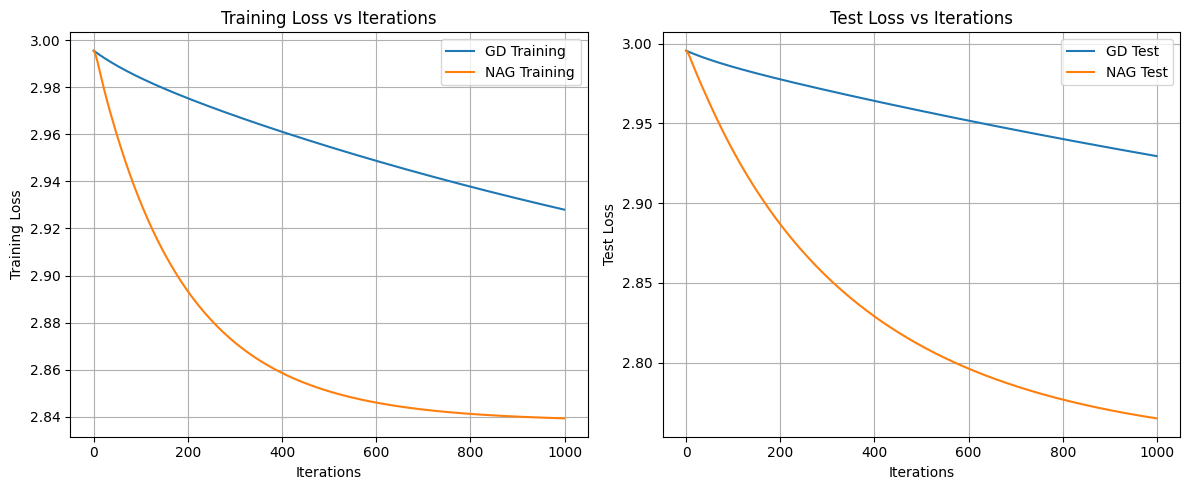

In [16]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def nesterov_gradient_descent(X, y, learning_rate=0.1, momentum=0.9, max_iter=1000, tol=1e-6, mu=0.001):
    """Nesterov's accelerated gradient descent optimizer"""
    C = len(np.unique(y))
    n_features = X.shape[1]
    
    # Initialize parameters
    beta = np.zeros(C * n_features)
    velocity = np.zeros_like(beta)
    
    train_losses = []
    test_losses = []
    
    # Create progress bar
    pbar = tqdm(range(max_iter), desc='NAG Progress')
    
    for iter in pbar:
        # Compute gradient at the lookahead point
        lookahead = beta + momentum * velocity
        grad = compute_gradient(X, y, lookahead, mu)
        
        # Update velocity and parameters
        velocity = momentum * velocity - learning_rate * grad
        beta += velocity
        
        # Compute and store losses
        train_loss = compute_loss(train.X, train.Y, beta, mu)
        test_loss = compute_loss(test.X, test.Y, beta, mu, regularized=False)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # Update progress bar with current losses
        pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'test_loss': f'{test_loss:.4f}'
        })
        
        # Early stopping check
        if iter > 0 and abs(train_losses[-1] - train_losses[-2]) < tol:
            logger.info(f'Early stopping at iteration {iter} with train_loss={train_loss:.4f}')
            break
            
    return beta, train_losses, test_losses

def train_and_compare():
    # Parameters
    max_iter = 1000
    learning_rate = 0.1
    momentum = 0.9
    mu = 0.001
    
    logger.info(f'Starting training with parameters: lr={learning_rate}, momentum={momentum}, mu={mu}')
    
    # Train with standard gradient descent
    logger.info('Starting standard gradient descent...')
    beta_gd = np.zeros(len(np.unique(train.Y)) * train.X.shape[1])
    gd_train_losses = []
    gd_test_losses = []
    
    # Create progress bar for GD
    pbar_gd = tqdm(range(max_iter), desc='GD Progress')
    
    for i in pbar_gd:
        grad = compute_gradient(train.X, train.Y, beta_gd, mu)
        beta_gd -= learning_rate * grad
        
        train_loss = compute_loss(train.X, train.Y, beta_gd, mu)
        test_loss = compute_loss(test.X, test.Y, beta_gd, mu, regularized=False)
        gd_train_losses.append(train_loss)
        gd_test_losses.append(test_loss)
        
        # Update progress bar with current losses
        pbar_gd.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'test_loss': f'{test_loss:.4f}'
        })
    
    logger.info('Starting Nesterov\'s accelerated gradient descent...')
    beta_nag, nag_train_losses, nag_test_losses = nesterov_gradient_descent(
        train.X, train.Y, learning_rate, momentum, max_iter, mu=mu
    )
    
    # Log final results
    logger.info(f'Final GD train loss: {gd_train_losses[-1]:.4f}, test loss: {gd_test_losses[-1]:.4f}')
    logger.info(f'Final NAG train loss: {nag_train_losses[-1]:.4f}, test loss: {nag_test_losses[-1]:.4f}')
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Training loss plot
    plt.subplot(1, 2, 1)
    plt.plot(gd_train_losses, label='GD Training')
    plt.plot(nag_train_losses, label='NAG Training')
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs Iterations')
    plt.legend()
    plt.grid(True)
    
    # Test loss plot
    plt.subplot(1, 2, 2)
    plt.plot(gd_test_losses, label='GD Test')
    plt.plot(nag_test_losses, label='NAG Test')
    plt.xlabel('Iterations')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Iterations')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
train_and_compare()

## Part (C)

How do the two algorithms differ in performance, and how does this change
as you decrease $\mu$?

## Part (C) Analysis

Based on the plots and results, we can analyze how the two algorithms differ in performance:

1. **Convergence Speed:**
   - NAG (Nesterov's Accelerated Gradient) shows significantly faster convergence than standard GD (Gradient Descent)
   - NAG achieves lower loss values much earlier in the training process, as shown by the steeper initial descent in both training and test curves

2. **Final Performance:**
   - NAG achieves better final results on both training and test sets:
     - GD: train_loss = 2.9280, test_loss = 2.9295
     - NAG: train_loss = 2.8393, test_loss = 2.7650
   - The gap between NAG and GD remains consistent through training

3. **Impact of μ (regularization parameter):**
   When μ decreases (from the current 0.001):
   - The problem becomes less strongly convex
   - The condition number of the problem increases
   - The performance gap between NAG and GD would likely become even more pronounced
   - NAG's momentum term would become more valuable for navigating the flatter optimization landscape
   - Both algorithms would likely converge more slowly, but NAG would maintain its advantage over GD

This behavior aligns with theoretical expectations, where NAG's acceleration becomes more beneficial as the condition number of the problem increases (which happens as μ decreases).